In [16]:
from dataclasses import dataclass, field, InitVar
from datetime import datetime
from typing import Any, Generator, Tuple

from bs4 import BeautifulSoup
import requests as req

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import pandas as pd
import seaborn as sns

Valuation = Tuple[np.datetime64, float]


In [32]:

@dataclass
class ETFData:
    id: str
    name: str
    name_CN: str
    invested: float
    units: float  # number of units
    unit_value: float = 0.0
    last_value: float = 0.0
    date_last_value: str = ""
    soup:BeautifulSoup = field(default=None, init=False, repr=False, compare=False)
    refresh:InitVar[bool] = True

    @property
    def total_value(self) -> float:
        """Current total value (i.e. all units)"""
        return float(self.units) * self.unit_value

    @property
    def total_value_last(self) -> float:
        """Current total value (i.e. all units) based on last value"""
        return float(self.units) * self.last_value

    def __post_init__(self, refresh:bool):
        if refresh:
            self.refresh()

    def _get_soup(self, force=False) -> BeautifulSoup:
        """Retrieve Soup with page content from East Money
        
        Args:
            force: Force update of date (default: False)
        """
        if self.soup is None or force:
            resp = req.get(f"http://fund.eastmoney.com/{self.id}.html")
            self.soup = BeautifulSoup(resp.text, 'html.parser')
        return self.soup

    def refresh(self) -> float:
        """"Refresh net values of ETF"""
        soup = self._get_soup()
        self.unit_value = float(soup.find(id="gz_gsz").text)
        self.date_last_value, self.last_value = next(self.last_valuations())

    def last_history(self, nb_values:int=2) -> Generator[Tuple[Any,...], None, None]:
        """Get last date and values (Unit net, Cumulative Net, and % growth)"""
        assert nb_values >= 2, "Number of values shall be >= 2"
        values_block = self._get_soup().find_all(class_="position_shares")[1]
        for line in values_block.find_all("tr")[1:]:
            values = [v.text for v in line.find_all("td")]

            date = values[0]
            valuations = [v if "%" in v else float(v)for v in values[1:]]
            
            # As some dates might just have day & month, we might need to add the year
            if date.count("-") == 1:
                date = f"{datetime.now().year}-{date}"

            yield tuple([np.datetime64(date)] + valuations[1:nb_values])

    def last_valuations(self) -> Generator[Valuation, None, None]:
        """Get date and values of last unit net value"""
        return self.last_history(2)

    @property
    def df(self) -> pd.DataFrame:
        """Get Dataframe of a given ETF (without duplicates)"""
        df = pd.read_csv(f"{self.id}.csv", parse_dates=["Date"])[["Date","Unit Net Value"]]
        df["ETF"] = f"{self.id} - {self.name}"
        df.drop_duplicates(subset=["Date"], inplace=True)
        return df

ETFS = [
    ETFData("001668", "Global Mobile","汇添富全球互联",  90_000.0, 47_679.15),
    ETFData("000041",  "Huaxia Global","华夏全球股票",  90_000.0, 87_499.15),
    ETFData("206011", "US Estate", "鹏华美国房地产", 45_000.0, 56_014.10),
]


2020-06-18 1.209
2020-06-17 1.213
2020-06-16 1.209
2020-06-15 1.205
2020-06-12 1.19
2020-06-11 1.173
2020-06-10 1.199
2020-06-09 1.207
2020-06-08 1.205
2020-06-05 1.202
2020-06-04 1.188
(numpy.datetime64('2020-06-18'), 1.209, '-0.48% ')
(numpy.datetime64('2020-06-17'), 1.213, '0.48% ')
(numpy.datetime64('2020-06-16'), 1.209, '0.48% ')
(numpy.datetime64('2020-06-15'), 1.205, '1.84% ')
(numpy.datetime64('2020-06-12'), 1.19, '2.13% ')
(numpy.datetime64('2020-06-11'), 1.173, '-3.16% ')
(numpy.datetime64('2020-06-10'), 1.199, '-0.96% ')
(numpy.datetime64('2020-06-09'), 1.207, '0.24% ')
(numpy.datetime64('2020-06-08'), 1.205, '0.36% ')
(numpy.datetime64('2020-06-05'), 1.202, '1.72% ')
(numpy.datetime64('2020-06-04'), 1.188, '-1.81% ')


In [3]:
START_DATE = "2020-04-17"

etf_dfs = [etf.df for etf in ETFS]
# etf_keys = [f"{e.id}-{e.name}" for e in ETFS]
etf_history = pd.concat(etf_dfs)
# etf_keys = [f"{e.id}-{e.name}" for e in ETFS]
etf_history = pd.concat(etf_dfs)

to_plot = etf_history.pivot(index="Date", columns="ETF", values="Unit Net Value").dropna()
to_plot = to_plot[(to_plot != 0.0).all(1)]
to_plot = to_plot / to_plot.loc[START_DATE] * 100
etf_history.tail(20)
to_plot.loc[START_DATE:].tail(20)
# to_plot.dtypes

ETF,000041 - Huaxia Global,001668 - Global Mobile,206011 - US Estate
Date,,,
2020-05-21,107.115010,108.994146,96.410891
2020-05-22,106.335283,107.557211,98.391089
2020-05-26,106.920078,109.473124,100.000000
2020-05-27,105.653021,108.249069,101.485149
2020-05-28,105.555556,108.036189,103.094059
2020-05-29,107.504873,110.643960,102.846535
2020-06-01,108.674464,112.506652,103.341584
2020-06-02,108.284600,112.772751,102.351485
2020-06-03,108.576998,113.783928,102.351485


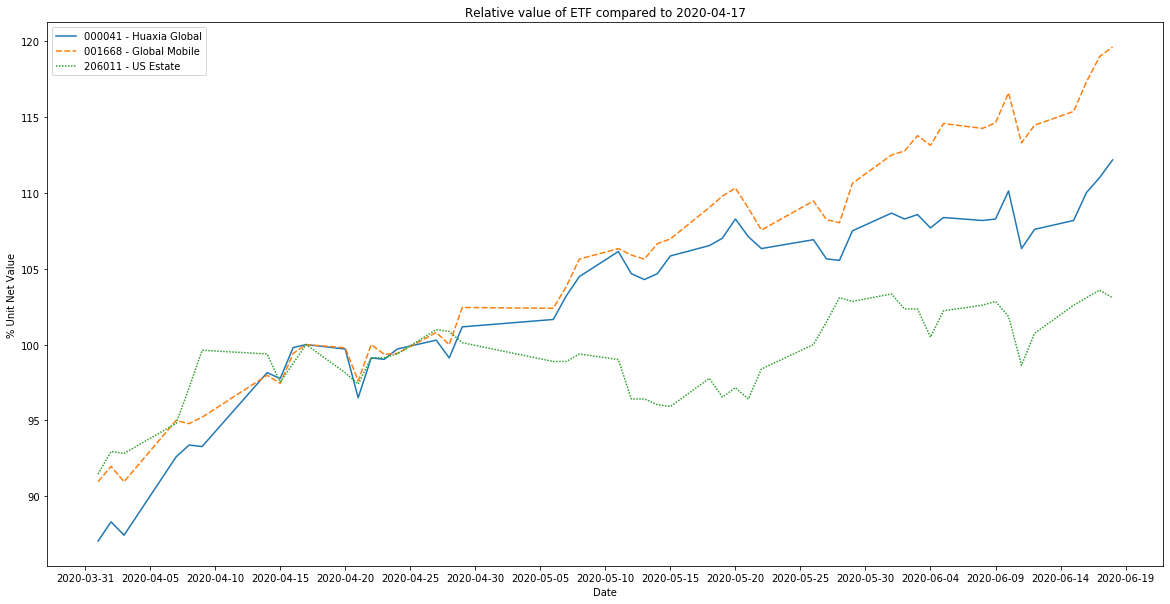

In [4]:
loc = plticker.MultipleLocator(base=3.0) # We want to put a tick every few days 
loc = plticker.MultipleLocator(base=5.0) # We want to put a tick every few days 

plt.figure(figsize=(20, 10))
plt.title(f"Relative value of ETF compared to {START_DATE}")
plt.ylabel("% Unit Net Value")
axes = sns.lineplot(data=to_plot.loc["2020-04-01":])
# axes = sns.lineplot(data=to_plot.loc["2020-04-01":START_DATE])
# axes = sns.lineplot(data=to_plot.loc[START_DATE:])
axes.xaxis.set_major_locator(loc)
# plt.axvline(x=START_DATE)

In [10]:

import altair as alt

def get_relative(df:pd.DataFrame) -> pd.DataFrame:
    """Return DataFrame relative to start value"""
    ref_value = float(df[df["Date"] == START_DATE]["Unit Net Value"])
    df["Relative Net Value"] = df["Unit Net Value"] / ref_value
    return df

etf_relative = [get_relative(df) for df in etf_dfs]
etf_history_relative = pd.concat(etf_relative)
etf_history_relative.head()


data = alt.Chart(etf_history_relative).mark_line().encode(
    alt.X('Date:T'),
    alt.Y('Relative Net Value:Q', scale=alt.Scale(zero=False), axis=alt.Axis(format='%')),
    color='ETF',
    strokeDash='ETF',
)

# start_points = pd.DataFrame([{"Date":np.datetime64(START_DATE) , "Ref": 1.0, "ETF": "N/A"}])
start_points = etf_history_relative[etf_history_relative["Date"] == START_DATE]
start_rule = alt.Chart(start_points).mark_rule().encode(
    alt.X('Date:T'),
    alt.Y('Relative Net Value:Q', scale=alt.Scale(zero=False), axis=alt.Axis(format='%')),
    color='ETF',
).properties(width=1000, height=500)
alt.layer(data, start_rule).interactive()

alt.LayerChart(...)